### Import Statements

In [339]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

In [340]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [341]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [342]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [343]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [344]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [345]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [346]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [347]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [348]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [349]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [350]:
data.shape

(30647, 24)

In [351]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [352]:
data['holiday'] = data.holiday.astype(int)

In [353]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [354]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [355]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [356]:
data.shape

(30647, 24)

### Drop the Number of Passengers

In [357]:
data.drop(["num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [358]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [359]:
data.drop(['Avg_Delay_Departing'], axis=1, inplace=True)

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [360]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

In [361]:
data.head()

,pickup_time,num_pickups,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0


### Dropping Month, HourOfDay, DayOfWeek

In [362]:
data.drop(['Month', 'HourOfDay', 'DayOfWeek'], axis=1, inplace=True)

In [363]:
data.head()

,pickup_time,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0


In [364]:
data.set_index("pickup_time", inplace=True)

#  LSTM models start from here

In [365]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,
2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0
2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0


### Create Lagging Timestep Columns

In [366]:
yt = data['num_pickups']

In [367]:
yt.head()

pickup_time
2014-01-01 00:00:00-05:00    107.0
2014-01-01 01:00:00-05:00     34.0
2014-01-01 02:00:00-05:00     34.0
2014-01-01 03:00:00-05:00     12.0
2014-01-01 04:00:00-05:00     25.0
Name: num_pickups, dtype: float64

In [368]:
yt.tail()

pickup_time
2017-06-30 19:00:00-04:00    457.0
2017-06-30 20:00:00-04:00    361.0
2017-06-30 21:00:00-04:00    433.0
2017-06-30 22:00:00-04:00    384.0
2017-06-30 23:00:00-04:00    335.0
Name: num_pickups, dtype: float64

In [369]:
yt_1 = yt.shift(1)
yt_2 = yt.shift(2)
yt_3 = yt.shift(3)
yt_4 = yt.shift(4)

In [370]:
reframed = pd.concat([yt, yt_1, yt_2, yt_3, yt_4], axis=1)

In [371]:
reframed.columns = ['yt', 'yt_1', 'yt_2', 'yt_3', 'yt_4']

In [372]:
reframed.head()

,yt,yt_1,yt_2,yt_3,yt_4
pickup_time,,,,,
2014-01-01 00:00:00-05:00,107.0,NaN,NaN,NaN,NaN
2014-01-01 01:00:00-05:00,34.0,107.0,NaN,NaN,NaN
2014-01-01 02:00:00-05:00,34.0,34.0,107.0,NaN,NaN
2014-01-01 03:00:00-05:00,12.0,34.0,34.0,107.0,NaN
2014-01-01 04:00:00-05:00,25.0,12.0,34.0,34.0,107.0


### Combine Lagging Timesteps and  Feature Variables

In [373]:
reframed = pd.concat([reframed, 
       
        data[[u'temp', u'humidity', u'wind_speed', u'Passengers',
       u'holiday', u'precip_in', u'Avg_Delay_Arriving',
       u'Cancelled_Departing_Flights', u'clear', u'clouds', u'fog', u'rain',
       u'snow', u'thunderstorm']]
                      
    ], axis=1)

In [374]:
reframed = reframed.dropna()

In [375]:
reframed.head()

,yt,yt_1,yt_2,yt_3,yt_4,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,,,,,
2014-01-01 04:00:00-05:00,25.0,12.0,34.0,34.0,107.0,268.10,80.0,3.0,0.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 05:00:00-05:00,16.0,25.0,12.0,34.0,34.0,268.02,80.0,1.0,243.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 06:00:00-05:00,14.0,16.0,25.0,12.0,34.0,267.90,80.0,1.0,141.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 07:00:00-05:00,21.0,14.0,16.0,25.0,12.0,267.59,80.0,1.0,717.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 08:00:00-05:00,94.0,21.0,14.0,16.0,25.0,267.67,80.0,0.0,797.0,1,0.0,2.666667,0.0,1,0,0,0,0,0


In [376]:
y = reframed['yt']

In [377]:
y.head()

pickup_time
2014-01-01 04:00:00-05:00    25.0
2014-01-01 05:00:00-05:00    16.0
2014-01-01 06:00:00-05:00    14.0
2014-01-01 07:00:00-05:00    21.0
2014-01-01 08:00:00-05:00    94.0
Name: yt, dtype: float64

In [378]:
y.tail()

pickup_time
2017-06-30 19:00:00-04:00    457.0
2017-06-30 20:00:00-04:00    361.0
2017-06-30 21:00:00-04:00    433.0
2017-06-30 22:00:00-04:00    384.0
2017-06-30 23:00:00-04:00    335.0
Name: yt, dtype: float64

In [379]:
feature_cols = ['yt_1', 'yt_2', 'yt_3', 'yt_4', 
                'temp', 'humidity', 'wind_speed', 
                'Passengers', 'holiday', 'precip_in', 
                'Avg_Delay_Arriving', 'Cancelled_Departing_Flights', 
                'clear', 'clouds', 'fog', 'rain', 'snow', 'thunderstorm', 
                'temp', 'humidity', 'wind_speed', 'Passengers', 'holiday', 
                'precip_in', 'Avg_Delay_Arriving', 'Cancelled_Departing_Flights', 
                'clear', 'clouds', 'fog', 'rain', 'snow', 'thunderstorm']

In [380]:
X = reframed[feature_cols]

In [381]:
X.head()

,yt_1,yt_2,yt_3,yt_4,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 04:00:00-05:00,12.0,34.0,34.0,107.0,268.10,80.0,3.0,0.0,1,0.0,0.000000,0.0,1,0,0,0,0,0,268.10,80.0,3.0,0.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 05:00:00-05:00,25.0,12.0,34.0,34.0,268.02,80.0,1.0,243.0,1,0.0,0.000000,0.0,1,0,0,0,0,0,268.02,80.0,1.0,243.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 06:00:00-05:00,16.0,25.0,12.0,34.0,267.90,80.0,1.0,141.0,1,0.0,0.000000,0.0,1,0,0,0,0,0,267.90,80.0,1.0,141.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 07:00:00-05:00,14.0,16.0,25.0,12.0,267.59,80.0,1.0,717.0,1,0.0,0.000000,0.0,1,0,0,0,0,0,267.59,80.0,1.0,717.0,1,0.0,0.000000,0.0,1,0,0,0,0,0
2014-01-01 08:00:00-05:00,21.0,14.0,16.0,25.0,267.67,80.0,0.0,797.0,1,0.0,2.666667,0.0,1,0,0,0,0,0,267.67,80.0,0.0,797.0,1,0.0,2.666667,0.0,1,0,0,0,0,0


In [382]:
X.tail()

,yt_1,yt_2,yt_3,yt_4,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-30 19:00:00-04:00,486.0,467.0,565.0,365.0,302.36,43.0,3.0,302.0,0,0.0,41.000000,2.0,0,0,0,0,0,1,302.36,43.0,3.0,302.0,0,0.0,41.000000,2.0,0,0,0,0,0,1
2017-06-30 20:00:00-04:00,457.0,486.0,467.0,565.0,301.54,65.0,6.0,1203.0,0,0.0,39.000000,2.0,0,1,0,0,0,0,301.54,65.0,6.0,1203.0,0,0.0,39.000000,2.0,0,1,0,0,0,0
2017-06-30 21:00:00-04:00,361.0,457.0,486.0,467.0,300.21,65.0,5.0,1158.0,0,0.0,70.111111,3.0,0,0,1,0,0,1,300.21,65.0,5.0,1158.0,0,0.0,70.111111,3.0,0,0,1,0,0,1
2017-06-30 22:00:00-04:00,433.0,361.0,457.0,486.0,299.56,65.0,4.0,1116.0,0,0.0,91.750000,1.0,0,0,0,1,0,0,299.56,65.0,4.0,1116.0,0,0.0,91.750000,1.0,0,0,0,1,0,0
2017-06-30 23:00:00-04:00,384.0,433.0,361.0,457.0,298.55,65.0,7.0,250.0,0,0.0,122.111111,0.0,0,0,0,1,0,0,298.55,65.0,7.0,250.0,0,0.0,122.111111,0.0,0,0,0,1,0,0


### Scale the Data

In [383]:
scaler_X = MinMaxScaler(feature_range=(0, 1))

X = np.array(X)

X = scaler_X.fit_transform(X)

In [384]:
scaler_y = MinMaxScaler(feature_range=(0, 1))

y = np.array(y).reshape((len(y), 1))

y = scaler_y.fit_transform(y)

In [385]:
X.shape

(30643, 32)

In [386]:
y.shape

(30643, 1)

### Train Test Split

In [387]:
n_train_hours = 365 * 24 * 3

In [388]:
X_train = X[0 : n_train_hours, ]
X_test = X[n_train_hours:, ]

In [389]:
y_train = y[0 : n_train_hours]
y_test = y[n_train_hours:]

In [390]:
X_train = X_train.reshape(X_train.shape + (1,))

X_test = X_test.reshape(X_test.shape + (1,))

In [391]:
print X_train.shape[0], "examples"
print X_train.shape[1], "features"
print X_train.shape[2], "time step"

26280 examples
32 features
1 time step


### The Model

In [392]:
seed = 7

In [393]:
np.random.seed(seed)

In [395]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=50,
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 26280 samples, validate on 4363 samples
Epoch 1/100
 - 11s - loss: 0.1407 - val_loss: 0.1115
Epoch 2/100
 - 11s - loss: 0.1173 - val_loss: 0.1008
Epoch 3/100
 - 12s - loss: 0.1153 - val_loss: 0.0992
Epoch 4/100
 - 11s - loss: 0.1132 - val_loss: 0.0952
Epoch 5/100
 - 11s - loss: 0.1020 - val_loss: 0.0871
Epoch 6/100
 - 12s - loss: 0.0868 - val_loss: 0.0911
Epoch 7/100
 - 12s - loss: 0.0814 - val_loss: 0.0993
Epoch 8/100
 - 11s - loss: 0.0767 - val_loss: 0.0863
Epoch 9/100
 - 10s - loss: 0.0742 - val_loss: 0.0909
Epoch 10/100
 - 11s - loss: 0.0724 - val_loss: 0.0836
Epoch 11/100
 - 10s - loss: 0.0711 - val_loss: 0.0837
Epoch 12/100
 - 11s - loss: 0.0703 - val_loss: 0.0672
Epoch 13/100
 - 10s - loss: 0.0688 - val_loss: 0.0702
Epoch 14/100
 - 11s - loss: 0.0675 - val_loss: 0.0659
Epoch 15/100
 - 11s - loss: 0.0655 - val_loss: 0.0628
Epoch 16/100
 - 11s - loss: 0.0653 - val_loss: 0.0668
Epoch 17/100
 - 10s - loss: 0.0655 - val_loss: 0.0619
Epoch 18/100
 - 11s - loss: 0.0637 - val_l

### The Results

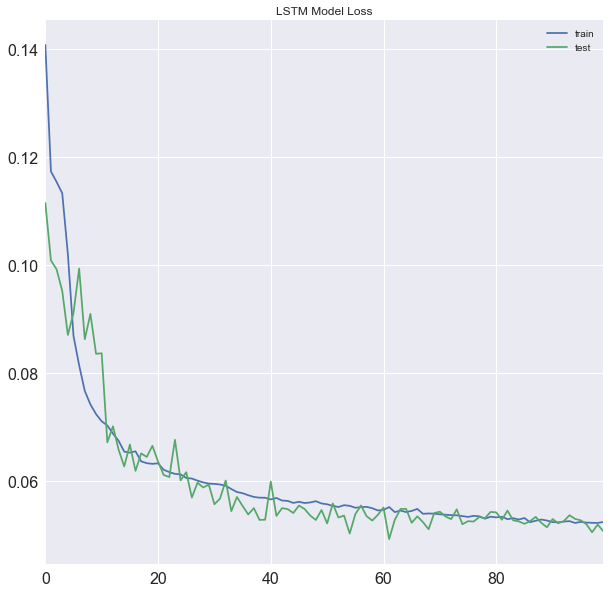

In [396]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');
plt.savefig("../images/lstm_model_loss.png")

In [397]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [398]:
score_train = model.evaluate(X_train, y_train, batch_size=50)

26280/26280 [==============================] - 2s 91us/step


In [399]:
score_test = model.evaluate(X_test, y_test, batch_size=50)

4363/4363 [==============================] - 0s 82us/step


In [400]:
print "in train MSE = ", round(score_train, 4)

in train MSE =  0.062


In [401]:
print "in test MSE ", round(score_test, 4)

in test MSE  0.0508


In [402]:
yhat = model.predict(X_test)

In [403]:
yhat = scaler_y.inverse_transform(np.array(yhat).reshape((len(yhat), 1)))

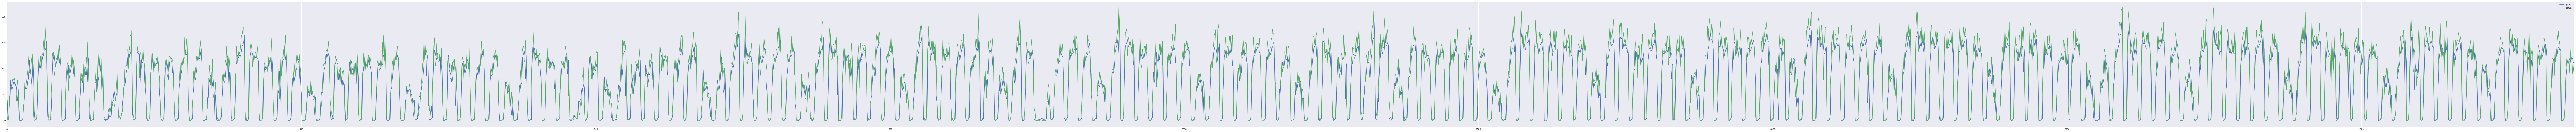

In [404]:
actual = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

results = pd.DataFrame()
results['pred'] = yhat[:,0]
results['actual'] = actual[:,0]
results.plot(figsize=(200,10))

In [405]:
# calculate r2
r2_score(actual, yhat)

0.84730586695862542

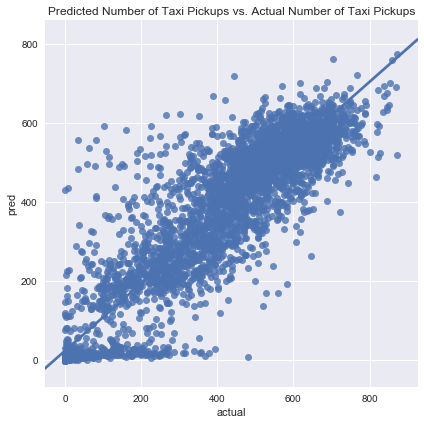

In [406]:
import seaborn as sns
sns.lmplot(x='actual',y='pred',data=results,fit_reg=True, size=6)
plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups")
plt.tight_layout()
plt.savefig("../images/lstm_model_pred_actual.png")